# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

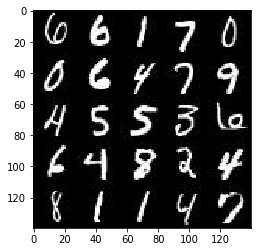

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

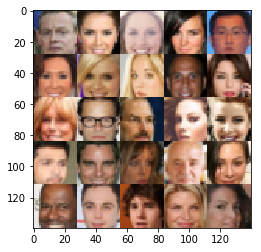

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape = [None, image_width, image_height, image_channels], name = 'input_real')
    input_z = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, shape = [], name = 'learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2

    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Use custom weight initialization. Xavier init is proposed to work best when working with GANs.
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=0.8)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    #try 0.1?
    #print(is_train)
    with tf.variable_scope('generator', reuse=not(is_train)):
        #?Try decreasing the width of layers from 512 -> 64. In context of GANs, a sharp decline in number of filters for Generator helps produce better results
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.8)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

    
    #?Use One Sided Label Smoothing for Discriminator loss, will help it generalize better. If you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
    #?A simple change like labels = tf.ones_like(d_logits_real) * np.random.uniform(0.7, 1.2) will help with the training process. This is known as label smoothing, typically used with classifiers to improve performance.
    #?However, only-one-sided label smoothing is recommended to weaken the D and not G.


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_seq, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
        saver.save(sess, './generator.ckpt')
    
    return losses           

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0507... Generator Loss: 6.3602
Epoch 1/2... Discriminator Loss: 0.1357... Generator Loss: 2.7088
Epoch 1/2... Discriminator Loss: 2.2052... Generator Loss: 0.4288
Epoch 1/2... Discriminator Loss: 2.2582... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 1.6810... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 1.6909... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.5739... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.9842... Generator Loss: 0.3551
Epoch 1/2... Discriminator Loss: 1.9083... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.7855... Generator Loss: 0.5784


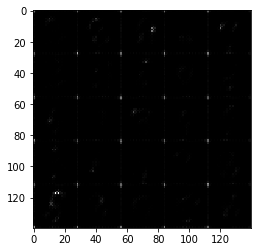

Epoch 1/2... Discriminator Loss: 1.9025... Generator Loss: 0.3166
Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.7395... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 1.7204... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 1.6718... Generator Loss: 0.5017
Epoch 1/2... Discriminator Loss: 1.6232... Generator Loss: 0.4410
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.5956... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 1.6404... Generator Loss: 0.4110


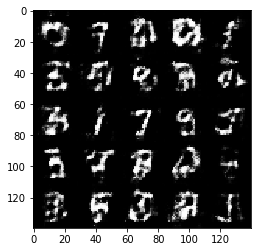

Epoch 1/2... Discriminator Loss: 1.5293... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 0.5537
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.6213... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.6191... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 1.7281... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.7645... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 1.6170... Generator Loss: 0.3507
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.7743


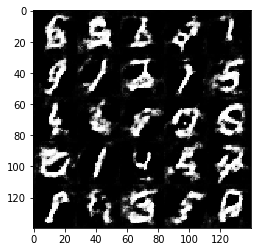

Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.5013... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.7444... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 1.5410... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.6836... Generator Loss: 0.4828
Epoch 1/2... Discriminator Loss: 1.7279... Generator Loss: 0.3113
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.5439


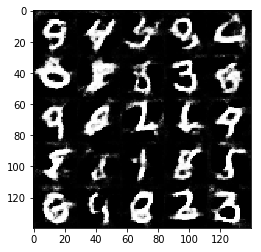

Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 1.5395... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.5020... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 1.5546... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.4550
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.5197


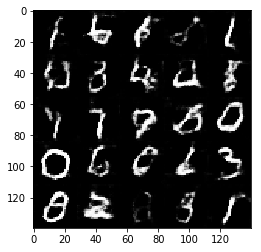

Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.6326... Generator Loss: 0.4104
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.5822... Generator Loss: 0.3896
Epoch 1/2... Discriminator Loss: 1.2299... Generator Loss: 0.7234


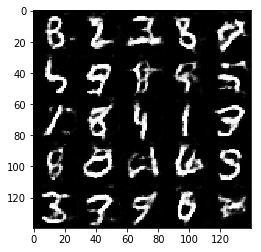

Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.5495... Generator Loss: 0.4388
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.4427
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.5474


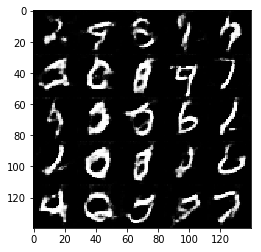

Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.6069
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.5763... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.6154
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.4383


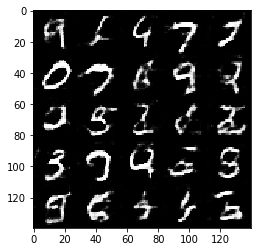

Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.3847
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.4731
Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.5763
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.5754
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.7661


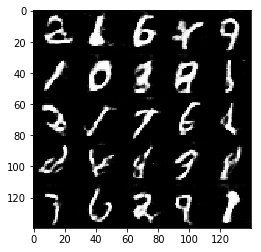

Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 0.2965
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.6382
Epoch 2/2... Discriminator Loss: 1.5452... Generator Loss: 0.3385
Epoch 2/2... Discriminator Loss: 1.5753... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.6045
Epoch 2/2... Discriminator Loss: 1.5313... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.6864


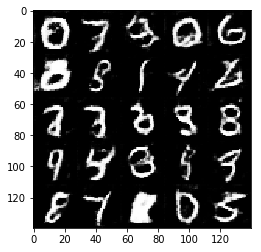

Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.7138
Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.4373
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 1.5887... Generator Loss: 0.4700
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 0.3871
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.5688


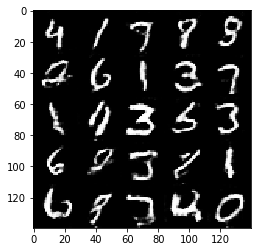

Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.5261
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.4615
Epoch 2/2... Discriminator Loss: 1.5264... Generator Loss: 0.3924
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.5534
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 2.2898... Generator Loss: 0.1488
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.6011


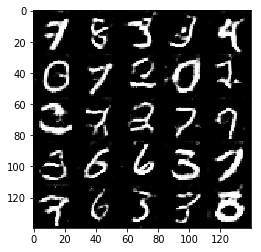

Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.4385
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.5481
Epoch 2/2... Discriminator Loss: 1.4437... Generator Loss: 0.5518
Epoch 2/2... Discriminator Loss: 1.5000... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.6192


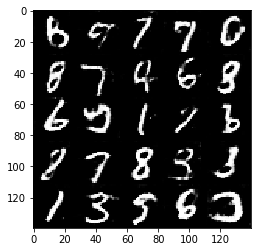

Epoch 2/2... Discriminator Loss: 1.3806... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.7798... Generator Loss: 0.2583
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.4613
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.4663
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 1.0308
Epoch 2/2... Discriminator Loss: 1.6582... Generator Loss: 0.3706


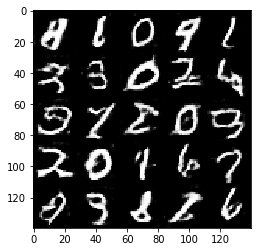

Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 0.8466
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.9417
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 1.2522
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.5523
Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 0.4920


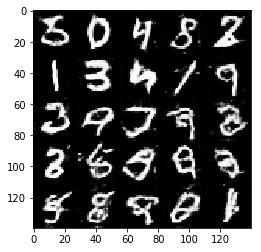

Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.4497
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.5488
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.8408


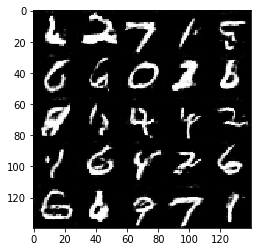

Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.3467
Epoch 2/2... Discriminator Loss: 1.5469... Generator Loss: 0.3797
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.5350
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.9077... Generator Loss: 0.2151
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 0.9474
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.6235
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.5431


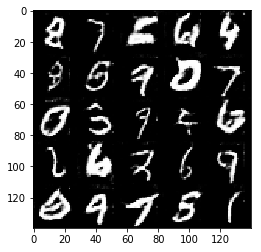

Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.4395
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.6334
Epoch 2/2... Discriminator Loss: 1.6166... Generator Loss: 0.3711
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.4392
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.5336


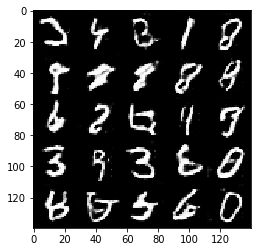

Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.6926... Generator Loss: 0.2875


In [23]:
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0008
#beta1 = 0.3
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    l=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

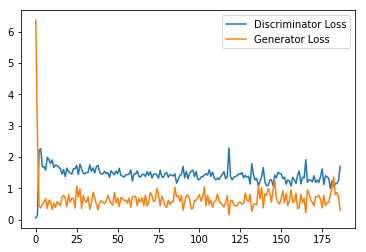

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
lpd = pd.DataFrame(l, columns = ['Discriminator Loss', 'Generator Loss'])
lpd.plot()


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 3.2257... Generator Loss: 10.8588
Epoch 1/1... Discriminator Loss: 3.2260... Generator Loss: 0.0866
Epoch 1/1... Discriminator Loss: 2.0053... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 3.2660... Generator Loss: 0.0545
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 2.9448
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 2.0444... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.9238... Generator Loss: 0.3401


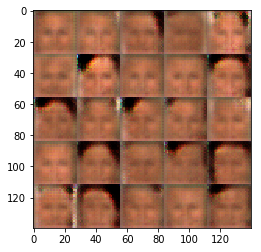

Epoch 1/1... Discriminator Loss: 1.8627... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 2.0528... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.7696... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 1.7882... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.8569... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.7528... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.7934... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.8047... Generator Loss: 0.7671


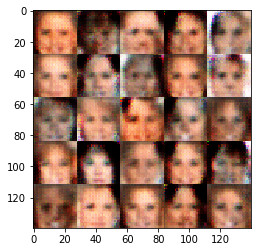

Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.7836... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.8058... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.9306... Generator Loss: 0.3876
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.8575... Generator Loss: 0.2351
Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.8222


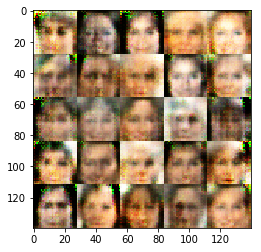

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.7467... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.4265
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7641


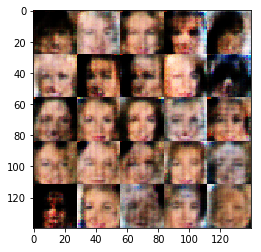

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 1.6412... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6850


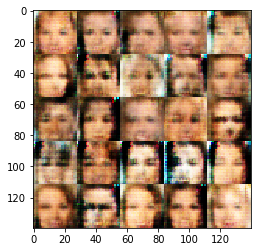

Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.7412... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.6867... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.3617


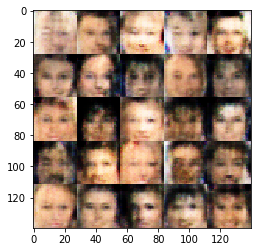

Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6383


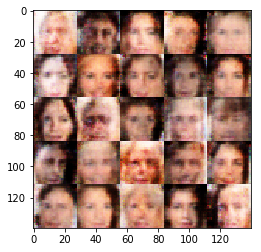

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 0.3163
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7322


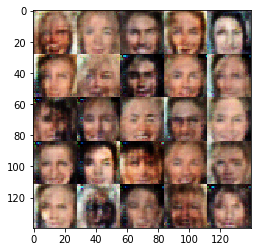

Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.6955... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6004


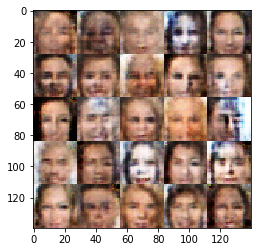

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6738


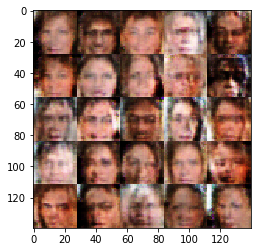

Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.9707... Generator Loss: 0.2113
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.5908


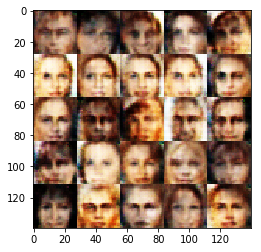

Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.5954


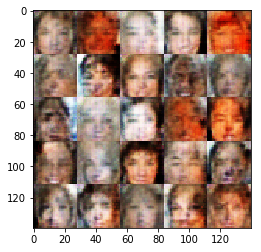

Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6266


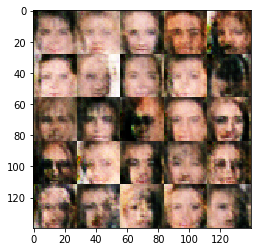

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5618


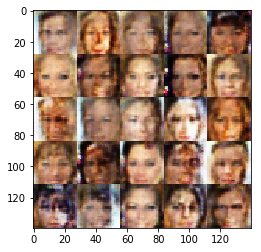

Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6278


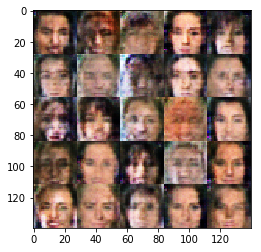

Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6948


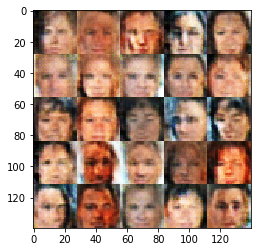

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6142


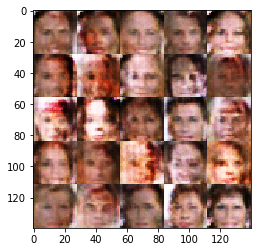

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6332


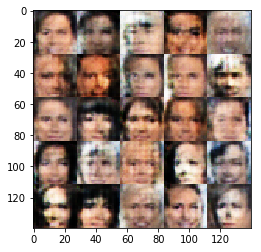

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6525


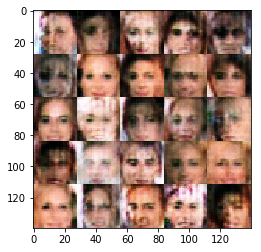

Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.5526


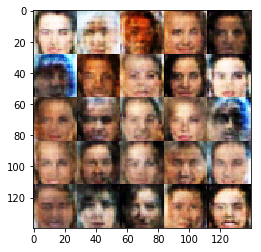

Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7022


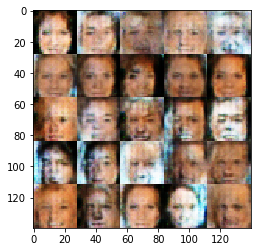

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6258


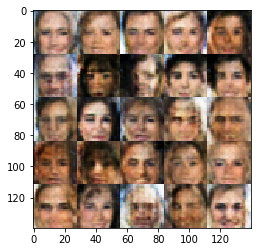

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5980


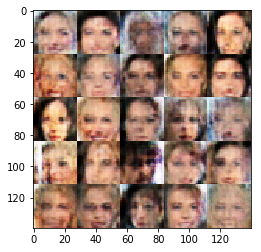

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.5261


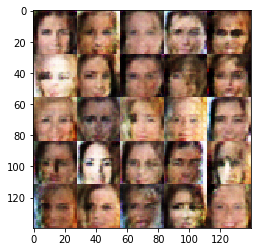

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6306


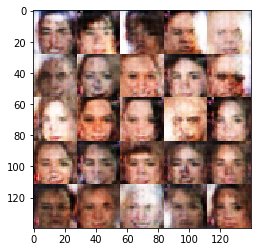

Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6762


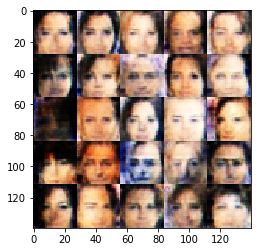

Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6400


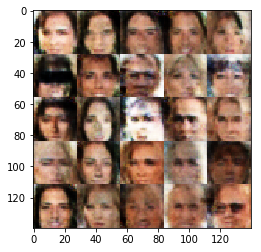

Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5866


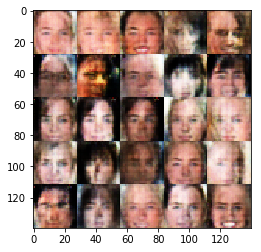

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6544


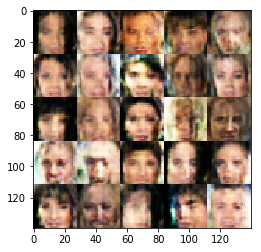

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5419


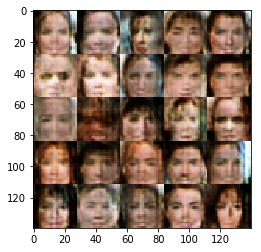

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6342


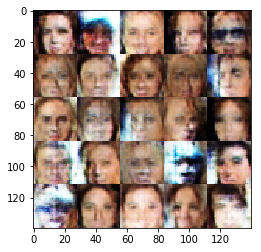

Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6659


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    ll = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

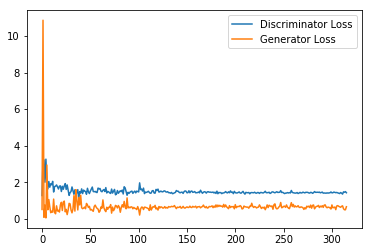

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
lpd = pd.DataFrame(ll, columns = ['Discriminator Loss', 'Generator Loss'])
lpd.plot()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.